In [98]:
!pip install explainable-ai-sdk==1.2.2
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import explainable_ai_sdk

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder
# from explainable_ai_sdk.model.configs import SampledShapleyConfig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.1/114.1 kB 1.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: explainable-ai-sdk
    Found existing installation: explainable-ai-sdk 1.2.4
    Uninstalling explainable-ai-sdk-1.2.4:
      Successfully uninstalled explainable-ai-sdk-1.2.4


In [67]:
!gsutil cp gs://financial_fraud_detection/fraud_data_kaggle.csv .

Copying gs://financial_fraud_detection/fraud_data_kaggle.csv...
| [1 files][303.4 MiB/303.4 MiB]                                                
Operation completed over 1 objects/303.4 MiB.                                    


In [68]:
data = pd.read_csv('fraud_data_kaggle.csv')
data = data.drop(columns=['type'])
data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [69]:
fraud = data[data['isFraud'] == 1]
not_fraud = data[data['isFraud'] == 0]

In [70]:
# Take a random sample of non fraud rows
not_fraud_sample = not_fraud.sample(random_state=2, frac=.005)

# Put it back together and shuffle
df = pd.concat([not_fraud_sample,fraud])
df = shuffle(df, random_state=2)

# Remove a few columns (isFraud is the label column we'll use, not isFlaggedFraud)
df = df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])

# Preview the updated dataset
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2880934,228,225995.98,187387.00,0.00,2089592.81,2315588.79,0.0
2485109,204,6758.80,25491.67,18732.88,0.00,0.00,0.0
3528108,259,21772.92,26341.00,4568.08,0.00,0.00,0.0
199110,13,582526.39,0.00,0.00,1110543.49,1693069.89,0.0
550022,21,93966.17,0.00,0.00,3581536.71,3675502.88,0.0


In [71]:
train_test_split = int(len(df) * .8)

train_set = df[:train_test_split]
test_set = df[train_test_split:]

train_labels = train_set.pop('isFraud')
test_labels = test_set.pop('isFraud')

In [72]:
scaler = StandardScaler()
train_set = scaler.fit_transform(train_set)
test_set = scaler.transform(test_set)

train_set = np.clip(train_set, -5, 5)
test_set = np.clip(test_set, -5, 5)

In [73]:
train_set

array([[ 0.74771568, -0.10558206, -0.24744663, -0.26469104,  0.51385876,
         0.48591169],
       [ 0.48352495, -0.33128635, -0.30457304, -0.25780596, -0.39568077,
        -0.43989138],
       [ 1.08896205, -0.31582934, -0.30427334, -0.26301209, -0.39568077,
        -0.43989138],
       ...,
       [-1.63000093, -0.2417149 ,  5.        ,  5.        , -0.32594475,
        -0.41332417],
       [ 0.50554084, -0.24271814, -0.31319682, -0.26469104, -0.39568077,
        -0.40279301],
       [-0.43013468, -0.28420772,  2.89581808,  3.09750739, -0.18409246,
        -0.26652501]])

In [74]:
weight_for_non_fraud = 1.0 / df['isFraud'].value_counts()[0]
weight_for_fraud = 1.0 / df['isFraud'].value_counts()[1]

class_weight = {0: weight_for_non_fraud, 1: weight_for_fraud}

In [75]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS):
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_set.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [76]:
EPOCHS = 100
BATCH_SIZE = 512

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [77]:
model = make_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                112       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [78]:
results = model.fit(
    train_set,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(test_set, test_labels),
    class_weight=class_weight)

Epoch 1/100
38/38 [==============================] - 2s 18ms/step - loss: 6.1193e-05 - tp: 1189.0000 - fp: 6538.0000 - tn: 9893.0000 - fn: 1520.0000 - accuracy: 0.5790 - precision: 0.1539 - recall: 0.4389 - auc: 0.5159 - val_loss: 0.6583 - val_tp: 389.0000 - val_fp: 1198.0000 - val_tn: 2886.0000 - val_fn: 313.0000 - val_accuracy: 0.6843 - val_precision: 0.2451 - val_recall: 0.5541 - val_auc: 0.6482
Epoch 2/100
38/38 [==============================] - 0s 5ms/step - loss: 5.6941e-05 - tp: 1489.0000 - fp: 6759.0000 - tn: 9672.0000 - fn: 1220.0000 - accuracy: 0.5831 - precision: 0.1805 - recall: 0.5496 - auc: 0.5973 - val_loss: 0.6456 - val_tp: 428.0000 - val_fp: 1136.0000 - val_tn: 2948.0000 - val_fn: 274.0000 - val_accuracy: 0.7054 - val_precision: 0.2737 - val_recall: 0.6097 - val_auc: 0.7157
Epoch 3/100
38/38 [==============================] - 0s 4ms/step - loss: 5.4125e-05 - tp: 1550.0000 - fp: 5658.0000 - tn: 10773.0000 - fn: 1159.0000 - accuracy: 0.6438 - precision: 0.2150 - recall:

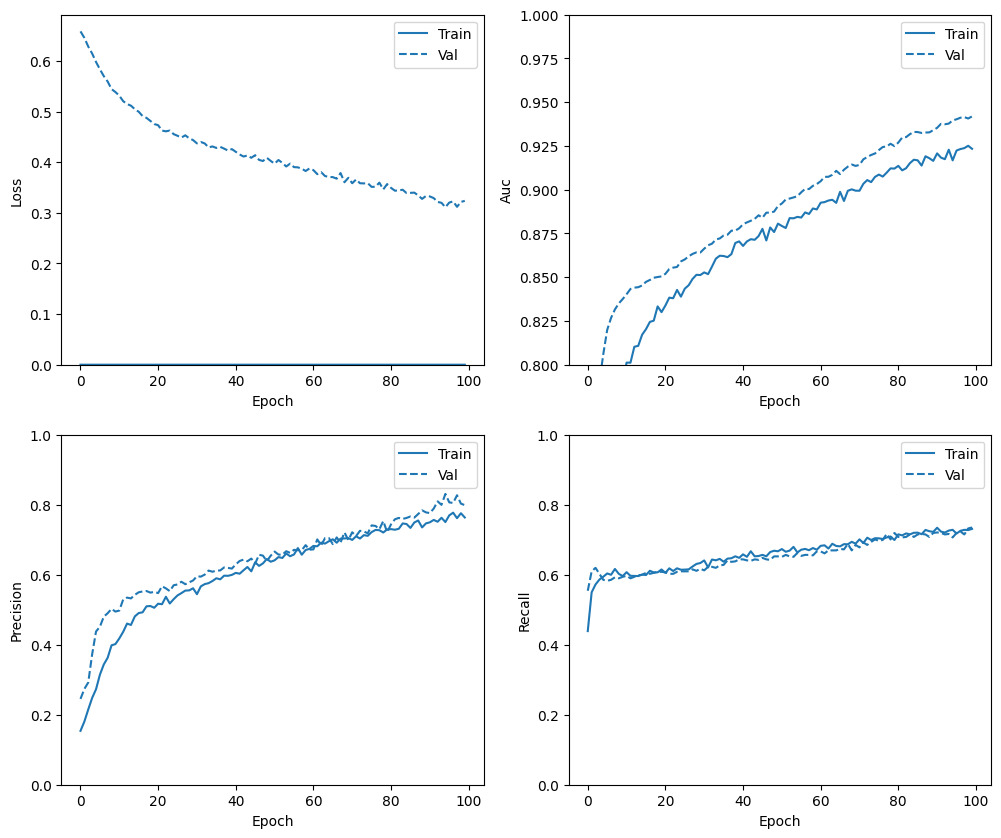

In [79]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(results)

In [80]:
predicted = model.predict(test_set)

y_pred = []

for i in predicted.tolist():
  y_pred.append(int(round(i[0])))

150/150 [==============================] - 0s 1ms/step


In [81]:
cm = confusion_matrix(test_labels.values, y_pred)
print(cm)

[[3954  130]
 [ 186  516]]


In [82]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

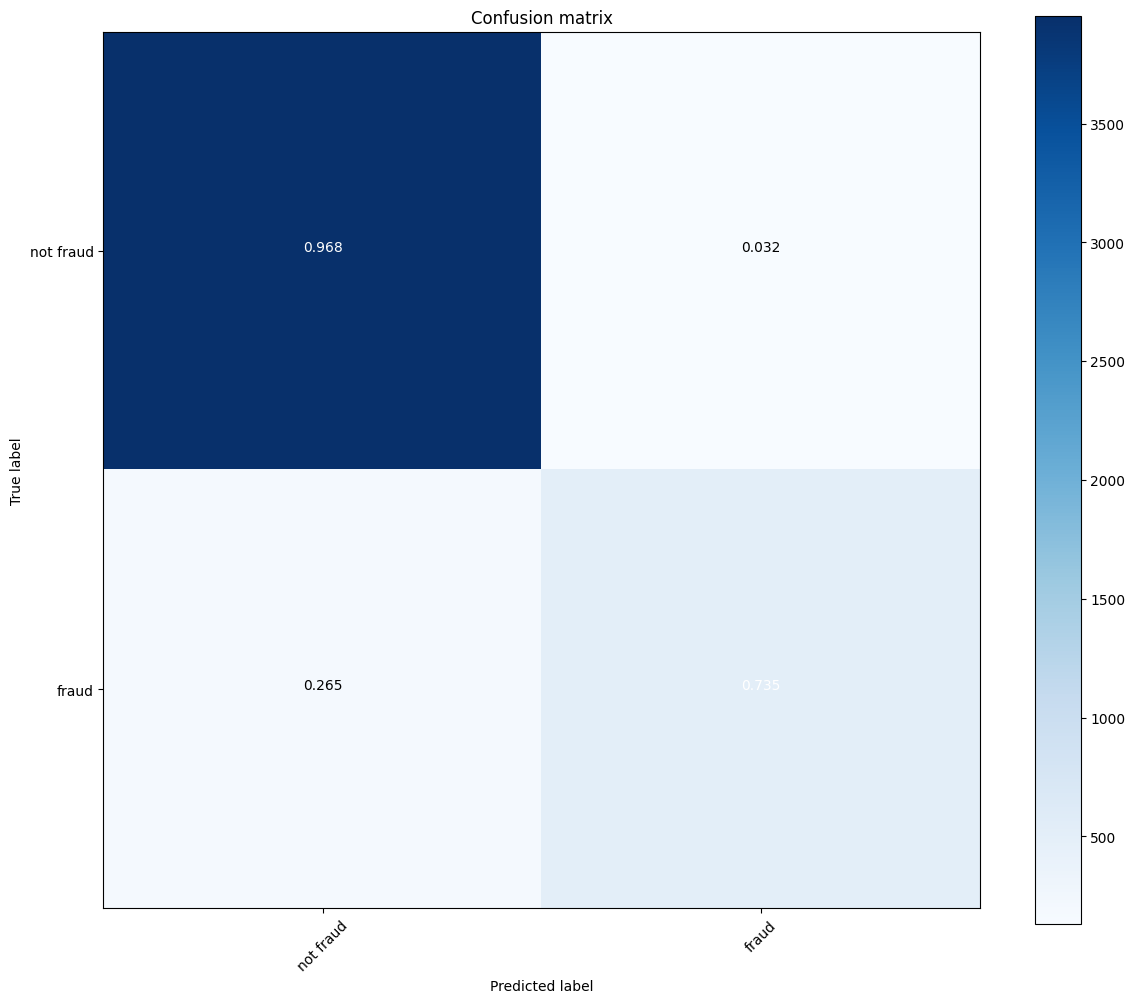

In [83]:
classes = ['not fraud', 'fraud']
plot_confusion_matrix(cm, classes, normalize=True)

In [84]:
model_dir = 'fraud_model'
tf.saved_model.save(model, model_dir)

INFO:tensorflow:Assets written to: fraud_model/assets


INFO:tensorflow:Assets written to: fraud_model/assets


In [85]:
model_builder = SavedModelMetadataBuilder(model_dir)
metadata = model_builder.get_metadata()
print(metadata)

{'outputs': OrderedDict([('dense_3', {'output_tensor_name': 'dense_3'})]), 'inputs': OrderedDict([('dense_2_input', {'input_tensor_name': 'dense_2_input', 'encoding': 'identity', 'modality': 'numeric'})]), 'framework': 'tensorflow2', 'tags': ['explainable_ai_sdk']}


In [86]:
not_fraud_sample = not_fraud_sample.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud', 'isFraud'])

baseline = scaler.transform(not_fraud_sample.values)
baseline = np.clip(baseline, -5, 5)
baseline_values = np.median(baseline, axis=0)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [87]:
input_name = list(metadata['inputs'])[0]
model_builder.set_numeric_metadata(input_name, input_baselines=[baseline_values.tolist()], index_feature_mapping=df.columns.tolist()[:6])
model_builder.save_metadata(model_dir)

In [99]:

local_model = explainable_ai_sdk.load_model_from_local_path(
    model_dir, 
    explainable_ai_sdk.SampledShapleyConfig()
)

AttributeError: module 'explainable_ai_sdk' has no attribute 'SampledShapleyConfig'

In [100]:
fraud_example = [0.722,0.139,-0.114,-0.258,-0.271,-0.305]
response = local_model.explain([{input_name: fraud_example}])
response[0].visualize_attributions()

NameError: name 'local_model' is not defined

In [93]:
local_model = explainable_ai_sdk.load_model_from_local_path(
    model_dir, 
    explainable_ai_sdk.SampledShapleyConfig(path_count=20)
)

AttributeError: module 'explainable_ai_sdk' has no attribute 'SampledShapleyConfig'